![Header Image](../assets/header_image.png "Header Image")

# Assignment 3: Semantic Point Cloud Segmentation

In this assignment, we will consider the topic __semantic point cloud segmentation__. It's very similar to semantic image segmentation, because we will use a 2D matrix representation of a point cloud in order to process it with the same approach than in __semantic image segmentation__.

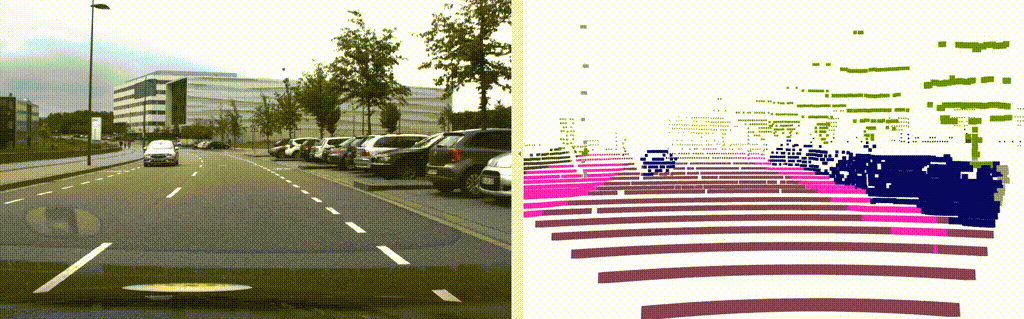

The example about depicts semantic point cloud segmentation. Each color represents a class such as road, sidewalk and car. This scene was captured at Campus Melaten (Aachen).

In this assignment we will walk through following steps:

- Load a dataset for semantic image segmentation
- Visualize a segmented point cloud
- Train a model for semantic point cloud segmentation
- Perform inference on a model for semantic point cloud segmentation

Let's start by importing all the necessary imports for this assignment:

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import glob

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

from easydict import EasyDict
import plotly.graph_objects as go


tf.random.set_seed(42)
random.seed(123)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

## Dataset Loading

Our labeled dataset for this assignment can be found in the directory `datasets/pcl_segmentation`. This dataset contains already a `training` and `validation` split. Each sample is a numpy `*.npy` which is the native format to store numpy ndarrays. Furthermore, each sample contains the input data and the corresponding label.

The dataset was __automatically annotated__. That means, a different neural network for __image segmentation__ was used to automatically annotate the points of the point cloud using a process called __cross modal label transfer__. 

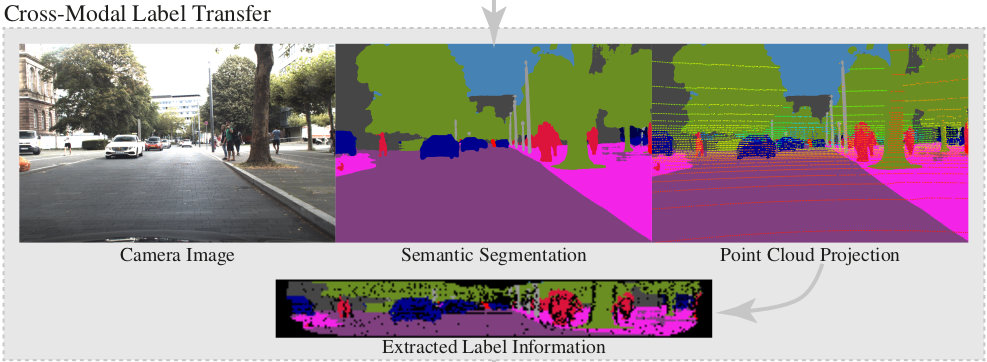


Hence, the annotations are not perfect, but for this assignment we won't bother about this fact. We can start by loading all file pathes:

In [ ]:
# relative pathes to the datasets
train_path = "datasets/pcl_segmentation/train"
val_path = "datasets/pcl_segmentation/val"

# get all file pathes
train_pathes = sorted(glob.glob(os.path.join(train_path, "*.npy")))
val_pathes = sorted(glob.glob(os.path.join(val_path, "*.npy")))

In [ ]:
print("Number of training samples: ", len(train_pathes))
print("Number of validation samples: ", len(val_pathes))

## Class Definitions

In the following we will set up some __class definitions__ for this assignment. Similar to the __image segmentation__ assignment we consider here a set of classes that are used for the segmentation task. The classes are quite similar to the classes in the image segmentation task, but are reduced here to make them more suitable for __point cloud segmentation__.

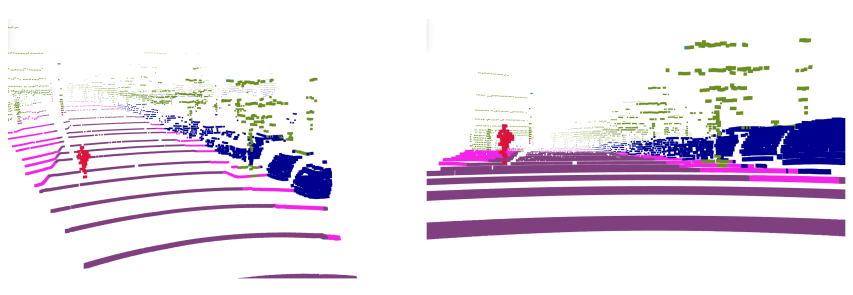

For example the class __sky__ does not exists here in this assignment, because it can not be detected by the LiDAR. Furthermore, classes which soley rely on textures such as __fence__, __wall__ or __building__ are reduced into a single class __building__. Theses classes can be distinguished using high-resolution camera images, but not in low-resolution LiDAR data. Hence, we will work with the following classes:

In [ ]:
cfg = EasyDict()

# Class name definitions
cfg.CLASSES = ['Road',
              'Sidewalk',
              'Building',
              'Pole',
              'Vegetation',
              'Person',
              'TwoWheeler',
              'Car',
              'Truck',
              'Bus',
              "None"]

cfg.NUM_CLASS = len(cfg.CLASSES)

# Color class association
# e.g. Index 0 corresponds to color [128, 64, 128] and class 'Road'
cfg.CLS_COLOR_MAP = np.array([[128,  64,  128],  # Road
                              [244,  35,  232],  # Sidewalk
                              [70,   70,   70],  # Building
                              [153, 153,  153],  # Pole
                              [107, 142,   35],  # Vegetation
                              [220,  20,   60],  # Person
                              [255,   0,    0],  # Two Wheeler
                              [0,     0,  142],  # Car
                              [0,     0,   70],  # Truck
                              [0,    60,  100],  # Bus
                              [0,     0,    0]   # None
                              ]) / 255.0

Note, that we are using the `EasyDict` instance `cfg` throughout the whole assignment. It allows us to store and access various variables quite easily. 

# Inspect the dataset

Now, let's have a detailed look into the dataset. We can start by loading a single sample with `np.load()`:

In [ ]:
sample = np.load(train_pathes[0])
print("Sample shape:", sample.shape)

You can see that the sample has a shape of `[32, 240, 6]`. Which means, it has a __height of 32__, __width of 240__ and __6 channels__. These structure was obtained by projecting the annotated pointcloud onto a 2D image. The height corresponds to the number of __layers__ of the LiDAR. The dataset was captured using a VLP 32-C laser scanner. The __width__ corresponds to a certain Field Of View where an automatic annotation of the point cloud was conducted.

Let's have a look on every channel of the point cloud. Each point can be associated with following fields:

In [ ]:
print("X-Coordinate in [m]: \t", sample[15, 121, 0])

print("Y-Coordinate in [m]: \t", sample[15, 121, 1])

print("Z-Coordinate in [m]: \t", sample[15, 121, 2])

print("Intensity: \t\t", sample[15, 121, 3])

print("Depth in [m]: \t\t", sample[15, 121, 4])

The depth for each point was calculated during the data aqcuisition step. It is simply the eucledian distance as shown in the following cell:

In [ ]:
print("Calculated Depth:", np.sqrt( sample[15, 121, 0]**2 + sample[15, 121, 1]**2 + sample[15, 121, 2]**2 ))

We can also have points in the tensor which are empty. LiDAR only produces data points on surfaces. If a laser beam does not hit a surface or hits a not reflective surface, then it is possible that we have missing points. 

In [ ]:
print("X-Coordinate in [m]: \t", sample[31, 120, 0])

print("Y-Coordinate in [m]: \t", sample[31, 120, 1])

print("Z-Coordinate in [m]: \t", sample[31, 120, 2])

print("Intensity: \t\t", sample[31, 120, 3])

print("Depth in [m]: \t\t", sample[31, 120, 4])

In that case, all data points are set to zero.

## Plot the Channels

We can also visualize each __channel__ of the point cloud matrix representation. In the following we will plot every channel of a sample.

In [ ]:
plt.imshow(sample[:, :, 0])
plt.title("X Coordinate")
plt.show()

plt.imshow(sample[:, :, 1])
plt.title("Y Coordinate")
plt.show()

plt.imshow(sample[:, :, 2])
plt.title("Z Coordinate")
plt.show()

plt.imshow(sample[:, :, 3])
plt.title("Intensity")
plt.show()

plt.imshow(sample[:, :, 4])
plt.title("Depth")
plt.show()

plt.imshow(sample[:, :, 5])
plt.title("Segmentation Map")
plt.show()

You will have probably noticed, that the left and right parts of the point cloud are not labelled. This is caused by the automatic labelling approach. Only LiDAR points that are visible in the Field Of View of the camera could be automaticall annotated. In this assignment, we will not bother about this problem and we will just accept it as our not-so-perfect training data.

## 3D Visualization of Training Samples

We can also use `plotly` to visualize the point cloud as a 3D model. Execute the following code block.

- Use `CTRL` + `Left mouse click` to shift the camera
- Use `Left mouse click` to pan the camera
- Use `Mouse Wheel` to Zoom in and out

In [ ]:
# Reshape in to a list of points with 6 features
list_of_points = sample.reshape((-1, 6))

# Extract x, y, z coordinates
points = list_of_points[:, :3]

# Get color information for every point
colors = cfg.CLS_COLOR_MAP[list_of_points[:, 5].astype(np.int32)]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1.75, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

# 2D Plot of the Label

## Task: Convert Segmentation Map to RGB Encoding

Similar to the function in the assignment semantic image segmentation, we will have to write a function that converts the segmentation map to the RGB encoding. As you may remember, in the previous assignment we computed the RGB using Tensorflow operations. This time we will use only `numpy` operations

#### Replace the `None` placeholders with your code


### Hints
- Store the shape of `segmentation_map` into shape. Use either `np.shape` or the `shape` attribute
- Flatten `segmentation_map` using numpy's function `flatten()`
- Convert the `segmentation_map` to `np.int32`. Use numpy's function `.astype()`
- Now you can use index slicing by applying `segmentation_map` to `class_color_map`. Remember that segmentation_maps now just contains int32 values which can be used as indexes
- Reshape `rgb_encoding` to the `[original height, original width, 3]`. Use the original shape for that which you have stored in `shape`. Use numpy's function `np.reshape()` or class function `.reshape()`

In [ ]:
def segmentation_map_to_rgb_encoding(segmentation_map, class_color_map):
    """
    Converts a segmentation class map into a RGB encoding
    
    Arguments:
    segmentation_map -- Numpy ndarray of shape [height, width] or [height, width, 1] containing class IDs of the defined classes
    class_color_map -- Numpy ndarray of shape [NUM_CLASSES, 3] which contains the RGB values for each class.
    
    Returns:
    rgb_encoding -- Numpy ndarray of shape [height, width, 3] which contains the RGB encoding of the segmentation map
    """
    
    ### START CODE HERE ###
    # Store the original shape of the segmentation map using ".shape"
    shape = None
    
    # Flatten segmentation map using ".flatten()"
    segmentation_map = None 
    
    # Convert the segmentation map into np.int32
    segmentation_map = None

    # Extract RGB values
    rgb_encoding = class_color_map[None]
    
    # Reshape to original width and height
    rgb_encoding = None
    ### END CODE HERE ###
    
    return rgb_encoding

### Test `segmentation_map_to_rgb_encoding`
Execute the following block. When you have implemented the function `segmentation_map_to_rgb_encoding` correctly, you would see the same output as in the block `Expected Output`

In [ ]:
fig = plt.figure(figsize=(16, 16))

grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 2),
                 axes_pad=0.1,
                 )

for i, ax in enumerate(grid):
    sample = np.load(train_pathes[i*6])
    segmentation_map = sample[:, :, 5]
    rgb_encoding = segmentation_map_to_rgb_encoding(segmentation_map, cfg.CLS_COLOR_MAP)
    ax.imshow(rgb_encoding)

### Expected Output

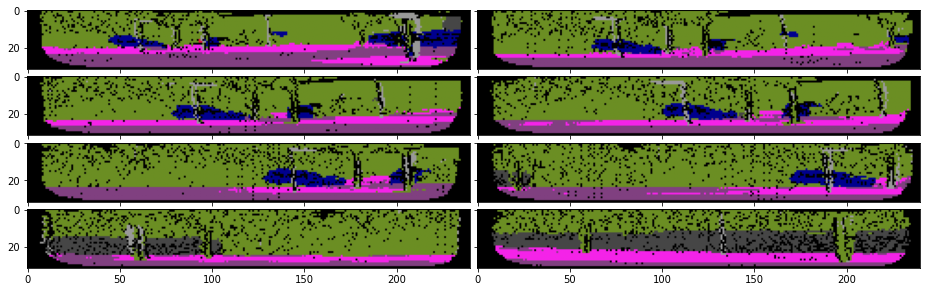

# Tensorflow Dataset Pipeline

We will now build a Tensorflow Pipeline on top of the dataset. We will use this pipeline later for the training of our point cloud segmentation network.

We can use the `cfg` dict to store some fundamental constants. From the dataset inspection we know that the 2D shape for each sample is `[32, 240]`. And we have for each point 5 features (x, y, z, intensity, depth) and a label. In this approach we will generate an additional feature of each point. That will be a binary mask if a point on the current position is existent or not. Hence, our input will have 6 features as shown in the following image: 

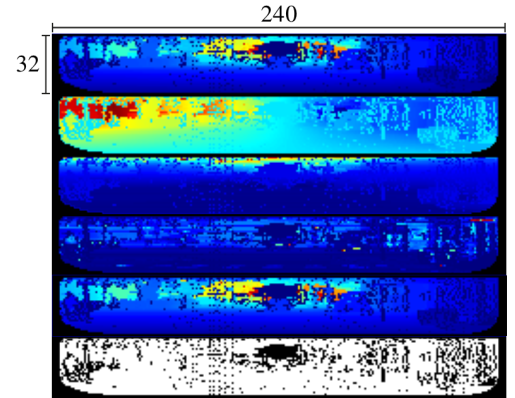

Each feature (x, y, z, intensity, depth, mask) is shown from top to bottom.


Furthermore, we set the batch size to 4. That means, 4 samples are packed together during the train steps. These parameters together define the __input shape__ of the network.

In [ ]:
# Input Shape
cfg.AZIMUTH_LEVEL = 240
cfg.ZENITH_LEVEL = 32
cfg.NUM_FEATURES = 6
cfg.BATCH_SIZE = 4

### Data Normalization Parameters
Data normalization can lead to a faster training performance. We have already computed for you the mean and standart deviation for all relevant input channels. You will have to use these values later in your input pipeline.

In [ ]:
# x, y, z, intensity, distance
cfg.INPUT_MEAN = np.array([[[24.810, 0.819, 0.000, 16.303, 25.436]]])
cfg.INPUT_STD =  np.array([[[30.335, 7.807, 2.058, 25.208, 30.897]]])

## Task: Implement `parse_sample`

In this task you will implement the `parse_sample` function which will read a `*.npy` sample file an returns `lidar` input data, a boolean `mask` and a segmentation map `label`.

#### Replace the `None` placeholders with your code


### Hints
- Retrieve the original shape of the sample by using `np.shape()`
- Get the lidar data and store it in variable `lidar`. Use index slicing to retrieve only the channels `x`, `y`, `z`, `intensity` and `depth`. Hence, get only the first 5 channels, but not the last one !
- Compute the mask of lidar input. The mask is `True` where the channel `depth > 0` and false in any other case. You can access the depth by using the index 4.
- Normalize the input tensor `lidar`. You can normalize data with the equation $\frac{X - \mu}{\sigma}$, where $X$ is your data, $\mu$ is the mean of the data and $\sigma$ the standard deviation of the data. Get the **mean** and **std** by using the configuration `cfg` directly e.g. `cfg.INPUT_MEAN`
- Set all values in `lidar` to zero, where the mask is `False`. That means set all values in `lidar` to zero where no point in the point cloud is present. You could use the `~` operator (bitwise negation operator) to invert the mask.
- Store the segmentation map in variable `label`. You can access the segmentation map by using the index 5. Use numpy's index slicing

In [ ]:
def parse_sample(sample_path):
    """
    Parses a data sample from a file path an returns a lidar tensor, a mask tensor and a label tensor
    
    Arguments:
    sample_path -- String - File path to a samle .npy file
    
    Returns:
    lidar -- numpy ndarray of shape [height, width, 5] containing the normalized lidar data
    mask -- numpy ndarray of shape  [height, width] containing a boolean mask
    label -- numpy ndarray of shape [height, width] containing the label as segmentation map
    """
    
    # Load numpy sample
    sample = np.load(sample_path.numpy()).astype(np.float32, copy=False)
    
    ### START CODE HERE ### 
    # Get original shape by using np.shape
    original_shape = None
    
    # Get x, y, z, intensity, depth
    lidar = sample[None, None, None]
    
    # Compute binary mask: True where the depth is bigger then 0, false in any other case
    mask = lidar[None, None, None] > None
    
    # Normalize input data using the mean and standard deviation
    lidar = (lidar - None) / None

    # Set lidar on all channels to zero where the mask is False. Ie. where no points are present
    lidar[None] = 0.0
    
    # Add Dimension to mask to obtain a tensor of shape [height, width, 1]
    mask = np.expand_dims(mask, -1)
    
    # Append mask to lidar input (No need to modify)
    lidar = np.append(lidar, mask, axis=2)
    
    # Squeeze mask (No need to modify)
    mask = np.squeeze(mask)
    
    # Get segmentation map from sample
    label = sample[None, None, None]
    
    ### END CODE HERE ###
    
    return lidar.astype('float32'), mask.astype('bool'), label.astype('int32')

### Test `parse_sample`

Run the following cell and compare the output with the expected output. The outputs should be identical if your implementation is correct.

In [ ]:
lidar, mask, label = parse_sample(tf.constant(train_pathes[0]))

print("Lidar Shape: \t", lidar.shape)
print("Mask Shape: \t", mask.shape)
print("Label Shape: \t", label.shape)

print("\nCheck Values:")
print(lidar[15, 121], lidar.dtype)
print(mask[15, 121], mask.dtype)
print(label[15, 121], label.dtype)

### Expected Output

## Task: Fix Tensorflow Shape

For some reasons, Tensorflow cannot determine the correct shapes when using numpy functions within the `tf.Data` pipeline. Hence, we have to implement the helper function `fix_shape` in order to assign the correct shape information to the tensors that were created with `parse_sample`.

#### Replace `None` placeholder with your code


### Hints
- Apply `batch_size` to the 0th dimension of lidar, mask and label
- Apply `cfg.ZENITH_LEVEL` to the 1st dimension of lidar, mask and label
- Apply `cfg.AZIMUTH_LEVEL` to the 2nd dimension of lidar, mask and label
- Remember that `lidar` is a tensor with `6` channels. Apply `6` it to the 3rd dimension
- __Note__ that this function also returns __two__ elements but has __three__ inputs. The first element is a Tuple consisting of __lidar__ and __mask__. The second element is the __label__. In that way, we have bundled the input to the network, which is the __lidar input__ and the __mask__ into one element. 

In [ ]:
def fix_shape(lidar, mask, label, batch_size):
    """
    Sets the correct shape information for the input tensors and the label tensor.
    
    Arguments:
    lidar -- tf.Tensor containing the lidar input tensor. tf.shape information are not assigned
    mask -- tf.Tensor with the lidar mask tensor. tf.shape information are not assigned
    label -- tf.Tensor with the label tensor.  tf.shape information are not assigned
    
    Returns:
    (lidar, mask) -- Tuple of two tf.Tensors:
                     - lidar tf.Tensor with shape [batch_size, height, width, 6]
                     - mask tf.Tensor with shape [batch_size, height, width]
    label -- tf.Tensor with shape [batch size, height, width]
    """
    
    ### START CODE HERE ### 
    lidar.set_shape([None, None, None, None])
    mask.set_shape([None,  None, None])
    label.set_shape([None, None, None]) 
    ### END CODE HERE ###
    
    return (lidar, mask), label

### Test `fix_shape`

Run the following cell and compare the output with the expected output. The output should be identical if your implementation is correct.

In [ ]:
(tf_lidar, tf_mask), tf_label = fix_shape(
                                 tf.expand_dims(tf.constant(lidar), 0),
                                 tf.expand_dims(tf.constant(mask), 0),
                                 tf.expand_dims(tf.constant(label), 0),
                                 batch_size=1
                                 )

print(tf.shape(tf_lidar))
print(tf.shape(tf_mask))
print(tf.shape(tf_label))

### Expected Output

## Task: Create Dataset

Now, we have implemented all necessary functions that are needed to create the `tf.data` input pipeline. Complete the function `create_dataset` which creates a `tf.data.Dataset` object based on a the list of pathes to the samples.

#### Replace the `None` placeholders with your code

### Hints
- Use `tf.data.Dataset.from_tensor_slices` to create an initial dataset instance. Use the `samples_pathes` as input.
- Shuffle the dataset by using the class function [.shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle). Use `buffer_size` as parameter.
- Use the function `parse_sample` in order to parse a sample from a given file path. Read the documentation of [tf.py_function()](https://www.tensorflow.org/api_docs/python/tf/py_function) and try to understand how the function `parse_sample` is applied.
- Batch the dataset with `batch_size`. Use the class function [.batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)
- Apply `fix_shape` to every batched dataset sample. Replace the `None` placeholder with the a function call of `fix_shape`. You might read the documentation about [.map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map). Don't forget to pass all the params this time. i.e. __lidar__, __mask__, __label__ and __batch size__

In [ ]:
def create_dataset(sample_pathes, batch_size, buffer_size=200):
    """
    Arguments:
    sample pathes -- List of Strings which contain pathes for the training samples
    
    Returns:
    dataset -- tf.data.Dataset
    """
    
    ### START CODE HERE ### 
    # create a tf.data.Dataset using sample_pathes
    dataset = None
    
    # Shuffle the dataset with buffer_size
    dataset = None
    
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(lambda sample: tf.py_function(None, [sample], [tf.float32, tf.bool, tf.int32]),
                          tf.data.AUTOTUNE)
    
    
    # Apply batching to the dataset using batch_size
    dataset = None
    
    # Fix the input shapes by applying the function fix_shape.   
    dataset = dataset.map(lambda lidar, mask, label: None,
                          tf.data.AUTOTUNE)
    
    # Use prefetching for better pipeline performance. (Do not modify)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    ### END CODE HERE ###
    
    return dataset

### Test `create_dataset`
Check the output of the following cell to check the implementation of `create_dataset`. Be aware that this test is not complete. It can only give you an indication if your implementation of above functions is correct.

In [ ]:
train = create_dataset(train_pathes, batch_size=4)
val = create_dataset(val_pathes, batch_size=1)


print("Length of the batched Train Dataset: ", tf.data.experimental.cardinality(train).numpy())
print(train)
print("Length of the batched Val Dataset: ", tf.data.experimental.cardinality(val).numpy())
print(val)

### Expected Output

# Network Architecture

Perfekt! We have now a working pipeline for our dataset. The LiDAR point cloud is encoded like a 2D image, but with 6 channels instead of 3 channels for a usual RGB image. Similar to semantic image segmentation, we can use a Convolutional Neural Network to process this representation. We will again use a segmentation map as our label in order to determine the loss and propagate the error signal through the network.

We will use a network architecture called __SqueezeSegV2__ which was designed for semantic image segmentation. You can read details about this architecture [here](https://arxiv.org/abs/1710.07368). The following image depicts the network architecture. You can see on the left hand side the input tensor and on the right hand side the corresponding label.

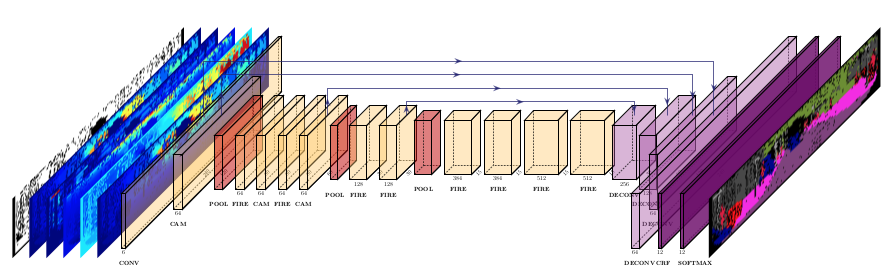

The network compresses the input down to a representation with small spatial size but with a higher number of channels. This representation is then upscaled with transposed convolutions to bring it back to the original size. You can see that the final layer computes the softmax probabilities for the corresponding output.

Let's define some constants using the dictionary __cfg__ which are necessary for building up the architecture.

In [ ]:
# Network
cfg.L2_WEIGHT_DECAY = 0.05
cfg.DROP_RATE = 0.1
cfg.BN_MOMENTUM = 0.9
cfg.REDUCTION = 16

We have also already implemented some custom layer architectures specifically designed for point cloud segmentation. Those are implemented in file `pcl_segmentation_utils.py`. We will import those layers with the following line of code.

In [ ]:
from segmentation_utils.pcl_segmentation_utils import CAM, FIRE, FIREUP

These layers consist of several 2D convolutional layers. If you are interested, feel free to read the implementation in `pcl_segmentation_utils.py` and the paper [SqueezeSegV2](https://arxiv.org/abs/1809.08495).

Now we are building of the whole model architecture. We will create a class called `SqueezeSegV2` which inherits from the base model class `tf.keras.Model`. We don't require you to implement any missing code snippets here, because the structure is quite complex. But if you are interested please read carefully the following code.

In [ ]:
class SqueezeSegV2(tf.keras.Model):
    """SqueezeSegV2 Model as custom Keras Model in TF 2.4"""

    def __init__(self, cfg):
        super(SqueezeSegV2, self).__init__()
        self.NUM_CLASS = cfg.NUM_CLASS
        self.CLASSES = cfg.CLASSES
        
        # input shape
        self.BATCH_SIZE = None
        self.ZENITH_LEVEL = cfg.ZENITH_LEVEL
        self.AZIMUTH_LEVEL = cfg.AZIMUTH_LEVEL
        self.NUM_FEATURES = cfg.NUM_FEATURES
        
        # regularization
        self.drop_rate = cfg.DROP_RATE
        self.l2 = cfg.L2_WEIGHT_DECAY
        self.bn_momentum = cfg.BN_MOMENTUM

        # Metrics
        self.miou_tracker = tf.keras.metrics.MeanIoU(num_classes=self.NUM_CLASS, name="MeanIoU")
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        
        # Loss function
        self.loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

        # Layers
        
        # Encoder
        self.conv1 = tf.keras.layers.Conv2D(
            input_shape=[self.ZENITH_LEVEL, self.AZIMUTH_LEVEL, self.NUM_FEATURES],
            filters=64,
            kernel_size=3,
            strides=[1, 2],
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=self.bn_momentum)
        self.cam1 = CAM(in_channels=64, bn_momentum=self.bn_momentum, l2=self.l2)

        self.conv1_skip = tf.keras.layers.Conv2D(
            input_shape=[self.ZENITH_LEVEL, self.AZIMUTH_LEVEL, self.NUM_FEATURES],
            filters=64,
            kernel_size=1,
            strides=1,
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.bn1_skip = tf.keras.layers.BatchNormalization(momentum=self.bn_momentum)

        self.fire2 = FIRE(sq1x1_planes=16, ex1x1_planes=64, ex3x3_planes=64, bn_momentum=self.bn_momentum, l2=self.l2)
        self.cam2 = CAM(in_channels=128, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire3 = FIRE(sq1x1_planes=16, ex1x1_planes=64, ex3x3_planes=64, bn_momentum=self.bn_momentum, l2=self.l2)
        self.cam3 = CAM(in_channels=128, bn_momentum=self.bn_momentum, l2=self.l2)

        self.fire4 = FIRE(sq1x1_planes=32, ex1x1_planes=128, ex3x3_planes=128, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire5 = FIRE(sq1x1_planes=32, ex1x1_planes=128, ex3x3_planes=128, bn_momentum=self.bn_momentum, l2=self.l2)

        self.fire6 = FIRE(sq1x1_planes=48, ex1x1_planes=192, ex3x3_planes=192, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire7 = FIRE(sq1x1_planes=48, ex1x1_planes=192, ex3x3_planes=192, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire8 = FIRE(sq1x1_planes=64, ex1x1_planes=256, ex3x3_planes=256, bn_momentum=self.bn_momentum, l2=self.l2)
        self.fire9 = FIRE(sq1x1_planes=64, ex1x1_planes=256, ex3x3_planes=256, bn_momentum=self.bn_momentum, l2=self.l2)

        # Decoder
        self.fire10 = FIREUP(sq1x1_planes=64, ex1x1_planes=128, ex3x3_planes=128, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire11 = FIREUP(sq1x1_planes=32, ex1x1_planes=64, ex3x3_planes=64, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire12 = FIREUP(sq1x1_planes=16, ex1x1_planes=32, ex3x3_planes=32, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)
        self.fire13 = FIREUP(sq1x1_planes=16, ex1x1_planes=32, ex3x3_planes=32, stride=2, bn_momentum=self.bn_momentum,
                             l2=self.l2)

        self.conv14 = tf.keras.layers.Conv2D(
            filters=self.NUM_CLASS,
            kernel_size=3,
            strides=1,
            padding='SAME',
            kernel_regularizer=tf.keras.regularizers.L2(l2=self.l2)
        )
        self.dropout = tf.keras.layers.Dropout(self.drop_rate)
        
        self.softmax = tf.keras.layers.Softmax(axis=-1)
    
    
    def call(self, inputs, training=False, mask=None):
        """
        Defines one forward pass of the network
        """
        lidar_input, lidar_mask = inputs[0], inputs[1]

        # Encoder
        x = tf.nn.relu(self.bn1(self.conv1(lidar_input)))

        cam1_output = self.cam1(x)

        conv1_skip = self.bn1_skip(self.conv1_skip(lidar_input))

        x = tf.nn.max_pool2d(cam1_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire2(x)
        x = self.cam2(x)
        x = self.fire3(x)
        cam3_output = self.cam3(x)

        x = tf.nn.max_pool2d(cam3_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire4(x)
        fire5_output = self.fire5(x)

        x = tf.nn.max_pool2d(fire5_output, ksize=3, strides=[1, 2], padding='SAME')
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        fire9_output = self.fire9(x)

        # Decoder
        x = self.fire10(fire9_output)
        x = tf.add(x, fire5_output)
        x = self.fire11(x)
        x = tf.add(x, cam3_output)
        x = self.fire12(x)
        x = tf.add(x, cam1_output)
        x = self.fire13(x)
        x = tf.add(x, conv1_skip)

        x = self.dropout(x)

        logits = self.conv14(x)
        
        probabilities, predictions = self.segmentation_head(logits, lidar_mask)
        
        return probabilities, predictions

    
    def segmentation_head(self, logits, lidar_mask):
        """
        The final layer of the segmentation network which performs the final segmentation.
        """
        with tf.name_scope("segmentation_head") as scope:
            probabilities = self.softmax(logits)

            predictions = tf.argmax(probabilities, axis=-1, output_type=tf.int32)

            # set predictions to the "None" class where no points are present
            predictions = tf.where(tf.squeeze(lidar_mask),
                                   predictions,
                                   tf.ones_like(predictions) * self.CLASSES.index("None")
                                   )
        return probabilities, predictions
    
    
    def train_step(self, data):
        """
        Performs one training step which is called during model.fit()
        """
        (lidar_input, lidar_mask), label = data

        with tf.GradientTape() as tape:
            probabilities, predictions = self([lidar_input, lidar_mask])  # forward pass
            loss = self.loss_function(label, probabilities)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update & Compute Metrics
        with tf.name_scope("metrics") as scope:
            self.loss_tracker.update_state(loss)
            self.miou_tracker.update_state(label, predictions)
            loss_result = self.loss_tracker.result()
            miou_result = self.miou_tracker.result()
        return {'loss': loss_result, 'miou': miou_result}
    
    
    def test_step(self, data):
        """
        Performs one test step which is called during model.evaluate() and during model.fit()
        """
        (lidar_input, lidar_mask), label = data

        probabilities, predictions = self([lidar_input, lidar_mask])  # forward pass

        loss = self.loss_function(label, probabilities)

        # Update Metrics
        self.loss_tracker.update_state(loss)
        self.miou_tracker.update_state(label, predictions)

        return {'loss': self.loss_tracker.result(), 'miou': self.miou_tracker.result()}

# Task: Model Setup

Now, we can simply create an instance of the `SqueezeSegV2()` class.

#### Replace the `None` place holders in the following cell

### Hints
- Don't forget to pass the configuration `cfg` class to `SqueezeSegV2()`
- Compile the model with the [Adam opimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam). You can use default parameters for this optimizer
- Use the classfunction [`.compile()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) to compile the model

In [ ]:
### START CODE HERE ### 

# Create an instance of `SqueezeSegV2`
model = None

# Compile the model with the Adam optimizer
None

### END CODE HERE ###

### Test Model Setup
Compare the output of the following cell with the expected output.

In [ ]:
print(type(model))
print(type(model.optimizer))

### Expected Output

# Model Training
Nice! Everything is now ready for training! We can train the model by calling `mode.fit()`. As the model architecture was optimized for performance, the training might progress quite fast compared to the image segmentation model in the previous assignment. Run the following cell to train the model with the `train` dataset:

In [ ]:
model.fit(train, epochs=10)

### Expected Output
You can expect an output similar to the following

Great! You can see that the loss is decreasing and the MIoU is increasing. That means our model is set up correctly and the training is running smoothly.

# Evaluate the model
Evaluate the model using the `evaluate()` class function and the `val` dataset

In [ ]:
model.evaluate(val)

### Expected Ouput

With only 10 epochs we can already achieve a MIoU of 32%! With a larger dataset and longer training we could easly increase the performance of the model. But this performance is enought for demonstration for this assignment. Now, let's use the trained model to perform inference.

# Model Inference
Let's take the trained model to perform inference on a sample of the validation set. We will perform the following steps

- Parse a sample from the validation set with `parse_sample`
- Add batch dimension to this sample
- Run the model by calling it
- Remove the batch dimension

In [ ]:
# Load a sample from the validation set
lidar, mask, label = parse_sample(tf.constant(val_pathes[0]))

# Add batch dimension
lidar = tf.expand_dims(lidar, axis=0)
mask = tf.expand_dims(mask, axis=0)

# Perform Inference
probabilities, predictions = model((lidar, mask))

# Remove batch dimension
predictions = tf.squeeze(predictions)
lidar = tf.squeeze(lidar)

In [ ]:
print("Prediction Shape:\t", predictions.shape)
print("Lidar Shape: \t\t", lidar.shape)

### Expected Output

#### Plot the prediction

In [ ]:
image = segmentation_map_to_rgb_encoding(predictions.numpy(), cfg.CLS_COLOR_MAP)
plt.imshow(image)
plt.title("Prediction")
plt.show()

image = segmentation_map_to_rgb_encoding(label, cfg.CLS_COLOR_MAP)
plt.imshow(image)
plt.title("Label")
plt.show()

The model performs already pretty good. The road, the sidewalk and the cars are detected pretty well. Now, we will do a 3D plot:

In [ ]:
# Convert lidar data to numpy ndarray 
points = lidar.numpy()
class_ids = predictions.numpy()

# Convert predictions into color encoding
colors = segmentation_map_to_rgb_encoding(class_ids, cfg.CLS_COLOR_MAP)
colors = colors.reshape((-1, 3))

# Reshape into a list of points
points = points.reshape((-1, 6))

# Denormalize back to original mean and std
points = (points[:, :5] * cfg.INPUT_STD) + cfg.INPUT_MEAN

# Remove unecessary 1st dimension
points = np.squeeze(points)

# Get x, y, z coordinates
points = points[:, :3]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1.75, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

Gratulations! You finished the Assignment `Semantic Point Cloud Segmentation`! Based on this approach it is possibel to perform several other perception tasks. 

E.g.
- It is possible to extract the __drivable area__ for the vehicle by isolating the road class
- The classes for objects such as __pedestrian__ or __car__ might be used for 3D object detection. A clustering algorithm can be applied for each of the isolated segmented classes

# Wrap Up
- You learned how a 3D point cloud can be represented as an image like tensor
- You learned how to visualized this representation as an image or 3D plot
- You learned how to set up a training pipeline for semantic point cloud segmentation
- You learned how to a neural network for image segmentation does look like and how it can be trained

# References

- [PCLSegmentation - Semantic Segmentation of LiDAR Point Clouds in Tensorflow 2.9.1 with SqueezeSeg - Github](https://github.com/ika-rwth-aachen/PCLSegmentation)

## License


MIT License

Copyright 2023 Institute for Automotive Engineering of RWTH Aachen University.